# Making stuff

In [1]:
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd")
import json
import collections
import itertools

import numpy as onp
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad, lax
from jax.scipy import stats
from jax.ops import index_update, index
import matplotlib.pyplot as plt

import numpy as onp
import jax
import pandas as pd
import haiku as hk
import ot

import config

import utils
import metrics
import time
import plot
import svgd
import stein
import kernels

from jax.experimental import optimizers

rkey = random.PRNGKey(0)
key, rkey = random.split(rkey)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Optimal encoding for funnel

In [2]:
def enc_funnel(z):
    """encode single sample z, shaped (d,)"""
    *x, y = z
    x, y = np.asarray(x), np.asarray(y)
    x_enc = x * np.exp(-y/2)
    return np.append(x_enc, y)

def dec_funnel(z):
    """decode single sample z, shaped (d,)"""
    *x, y = z
    x, y = np.asarray(x), np.asarray(y)
    x_dec = x * np.exp(y/2)
    return np.append(x_dec, y)


In [3]:
f = metrics.Funnel(2)
z = f.sample(1000)

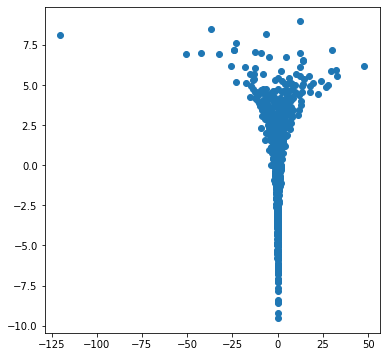

In [4]:
fig, ax = plt.subplots(figsize=[6,6])
ax.scatter(z[:, 0], z[:, 1])

In [5]:
encoded = vmap(enc_funnel)(z)

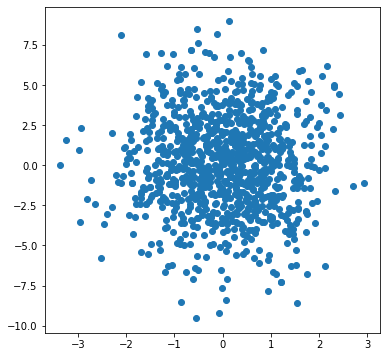

In [6]:
fig, ax = plt.subplots(figsize=[6,6])
ax.scatter(encoded[:, 0], encoded[:, 1])

In [7]:
np.all(vmap(dec_funnel)(encoded) - z < 0.001) 

DeviceArray(True, dtype=bool)

# Funnel distribution

In [8]:
f = metrics.Funnel(2)

In [9]:
s = f.sample(10)

In [10]:
f.logpdf(s[0])

DeviceArray(-4.17022026, dtype=float64)

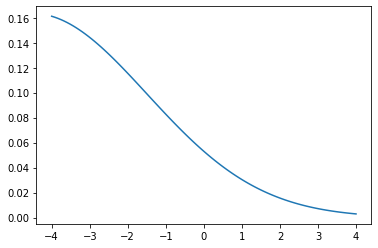

In [11]:
grid = np.linspace(-4, 4, 100)
grid2d = np.asarray([[0, y] for y in grid])
plt.plot(grid, vmap(f.pdf)(grid2d))

In [18]:
s = f.sample(1000)

(-8.0, 8.0)

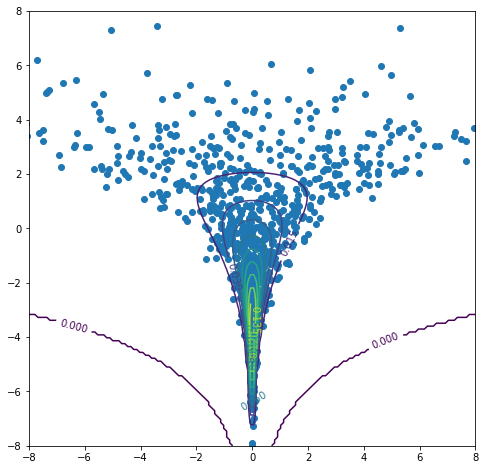

In [19]:
lims = (-8,8)
fig, ax = plt.subplots(figsize=[8,8])
CS = ax.contour(*plot.make_meshgrid(f.pdf, lims, num=150), levels=10)
ax.clabel(CS, inline=1, fontsize=10)
ax.scatter(s[:, 0], s[:, 1])
ax.set_ylim(*lims)
ax.set_xlim(*lims)

(-5.0, 5.0)

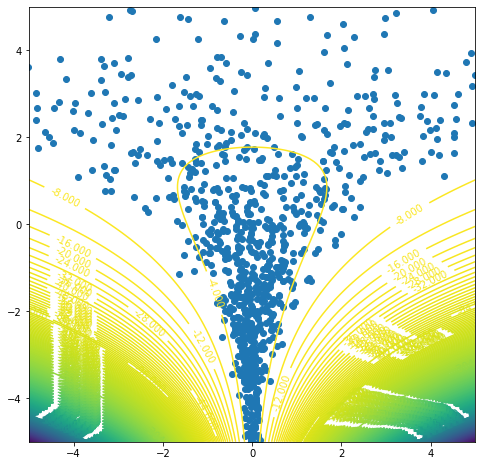

In [23]:
lims = (-5,5)
fig, ax = plt.subplots(figsize=[8,8])
CS = ax.contour(*plot.make_meshgrid(f.logpdf, lims, num=150), levels=500)
ax.clabel(CS, inline=1, fontsize=10)
ax.scatter(s[:, 0], s[:, 1])
ax.set_ylim(*lims)
ax.set_xlim(*lims)

In [15]:
# %matplotlib widget
# plot.plot_pdf(f.pdf, (-20, 20), type="3d")

In [16]:
lskdfj

NameError: name 'lskdfj' is not defined

# Resnet

In [ ]:
mlp_fn = kernels.make_mlp([2, 4, 4, 2], name="skippy", skip_connection=True)
mlp = hk.transform(mlp_fn)

In [ ]:
x = random.normal(rkey, (2,))
params = mlp.init(rkey, x)

In [ ]:
mlp.apply(params, None, x)

# Vmap and aux

In [ ]:
def f(x): return 2*x, 5

In [ ]:
np.mean(vmap(f)(np.ones(5)))

# Haiku identity

In [ ]:
def id_fn(x): return x
identity = hk.transform(id_fn)

In [ ]:
identity.init(rkey, 1.)

# Timing

In [ ]:
svgd = svgd.SVGD(**config.get_svgd_args(config.config))

In [ ]:
class Time():
    def start(self):
        self.lapstart = self.zero = time.time()
        
    def lap(self, name):
        duration = time.strftime("%M:%S", time.gmtime(time.time()-self.lapstart))
        print(name, duration)
        self.lapstart = time.time()
        
    def stop(self):
        total = time.strftime("%M:%S", time.gmtime(time.time()-self.zero))
        print("Total time elapsed:", total)

In [ ]:
d = metrics.Gaussian([0, 1], 1)
particles = d.sample(5000)

In [ ]:
n = len(particles)
target_sample = svgd.target.sample(n)
t = Time()

t.start()
emd = metrics.wasserstein_distance(particles, target_sample)
t.lap("EMD")
sinkhorn_divergence = ot.bregman.empirical_sinkhorn_divergence(particles, target_sample, 1, metric="sqeuclidean")
t.lap("Sinkhorn")
ksd = stein.ksd_squared(particles, particles, svgd.target.logpdf, kernels.ard(0))
t.lap("KSD")
se_mean = np.mean((np.mean(particles, axis=0) - svgd.target.mean)**2)
t.lap("Mean")
se_var = np.mean((np.cov(particles, rowvar=False) - svgd.target.cov)**2)
t.lap("Var")
t.stop()

# haiku use subnetwork somewhere else

In [ ]:
def encoder_fn(x):
    """can take kernel_params"""
    layer_sizes = [4, 4, 2]
    encoder = hk.nets.MLP(output_sizes=layer_sizes,
                    w_init=hk.initializers.VarianceScaling(scale=2.0),
                    activation=jax.nn.relu,
                    activate_final=False,
                    name="encoder")
    return encoder(x)
encoder = hk.transform(encoder_fn)

# unpacking `value_and_grad`

In [ ]:
def f(x, y): return x+y, "aux"
value_and_grad(f, argnums=(0, 1), has_aux=True)(1.,2.)

# plot errorbars

In [ ]:
def errorfill(x, y, yerr, color="r", alpha_fill=0.3, ax=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    ax.plot(x, y, color=color)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill)

In [ ]:
x = np.linspace(0, 10, 100)
y = np.log(x)
var = np.log(x) / 3

In [ ]:
errorfill(x, y, var)

# subsample

In [ ]:
random.normal(rkey, (10,3)).split(2)

In [ ]:
def subsample(key, array, n_subsamples, replace=True, axis=0):
    """
    Arguments
    ----------
    
    Returns
    ----------
    np.array of same shape as array except that the specified axis has length n_subsamples.
    consists of random samples from input array.
    """
    subsample_idx = random.choice(rkey, array.shape[axis], shape=(n_subsamples,), replace=replace)
    subsample = array.take(indices=subsample_idx, axis=axis)
    return subsample



In [ ]:
particles = random.normal(rkey, (10, 2))
rkey = random.split(rkey)[0]

subsample_idx = random.choice(rkey, len(particles), shape=(5,), replace=False) # set replace=True?
subsample = particles[subsample_idx]
rkey = random.split(rkey)[0]

print(subsample)
rkey = random.split(rkey)[0]


# finiteness

In [ ]:
t = np.array(1)
t = t / 0 # inf
t = t / t # NaN
t

In [ ]:
np.isfinite(t)

# Generate means, covs, weights

In [ ]:
A = onp.random.rand(4,4)

In [ ]:
A

In [ ]:
A.T

In [ ]:
def generate_pd_matrix(dim):
    A = onp.random.rand(dim, dim)
    return onp.matmul(A, A.T)

In [ ]:
def generate_parameters_for_gaussian(dim, k, mixture=True):
    means = onp.random.rand(k, dim) * 10 # random means in [0, 10]
    covs = [generate_pd_matrix(dim) for _ in range(k)]
    weights = onp.random.randint(1, 5, k)
    weights = weights / weights.sum()
    return means, covs, weights

In [ ]:
generate_parameters_for_gaussian(2, 3)

In [ ]:
d = metrics.GaussianMixture(*generate_parameters_for_gaussian(2, 3))

In [ ]:
plot.plot_pdf(d.logpdf, (-5., 15.), "contour", num_gridpoints=500)
plt.scatter(d.means[:, 0], d.means[:, 1])

In [ ]:
s = d.sample(10**3)

In [ ]:
plot.bivariate_hist(s)

# Wasserstein

In [ ]:
from scipy.spatial import distance

In [ ]:
coords = [(35.0456, -85.2672),
          (35.1174, -89.9711),
          (35.9728, -83.9422),
          (36.1667, -86.7833)]
distance.cdist(coords, coords, 'minkowski')
# array([[ 0.    ,  4.7044,  1.6172,  1.8856],
#        [ 4.7044,  0.    ,  6.0893,  3.3561],
#        [ 1.6172,  6.0893,  0.    ,  2.8477],
#        [ 1.8856,  3.3561,  2.8477,  0.    ]])

# stuff

In [ ]:
d = dict(chars="ab", nums=[1,2])
e = dict(words = ["bake", "tree"])

In [ ]:
p = utils.dict_cartesian_product(**d)
# list(p)
# [x for x in p]

In [ ]:
q = utils.dict_cartesian_product(**e)
# list(q)

In [ ]:
for a, b in itertools.product(p, q):
    print(a)
    print(b)
    print()

In [ ]:
[x for x in itertools.product(("a", "b", "c"), (1,2,3))]

# check if key in nested dict

In [ ]:
def nested_dict_contains_key(ndict: dict, key):
    if key in ndict:
        return True
    else:
        for k, v in ndict.items():
            if isinstance(v, collections.Mapping):
                if nested_dict_contains_key(v, key):
                    return True
        return False

In [ ]:
config.config